In [86]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.io import read_image
import json 
import copy

from dataset import *

data_p = Path('data/data.json')
with open(data_p, 'r') as f:
    data = json.load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


image dim: torch.Size([3, 73, 247])


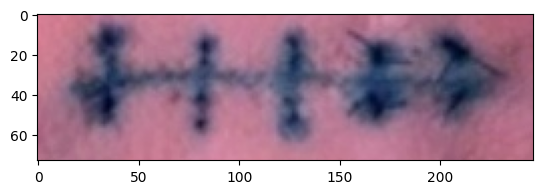

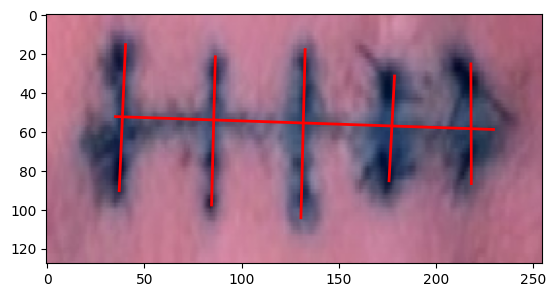

In [87]:
# torch interpolate
image_id = 123
size = (128,255)

annot = data[str(image_id)]
image_p = Path('data/images/default')/annot['file']

im = read_image(str(image_p))
inter_coeff = (size[0]/im.shape[1], size[1]/im.shape[2])  # the interpolation ratio

plt.imshow(im.permute(1, 2, 0))
print(f"image dim: {im.shape}")

im = im.unsqueeze(0)
im2 = F.interpolate(im, size=size) # size=(3,128,255)


im_toshow = im2[0].permute(1, 2, 0) 
fig, ax = plt.subplots()
ax.imshow(im_toshow)

# interpolate the annotation
for idx, label in enumerate(data[str(image_id)]['label']):
    points = data[str(image_id)]['points'][idx]
    x_coords, y_coords = zip(*points)
    x_coords = np.array(x_coords, dtype=float) * inter_coeff[1]
    y_coords = np.array(y_coords, dtype=float) * inter_coeff[0]
    ax.plot(x_coords, y_coords, color='red', linewidth=2)
plt.show()

In [3]:
# remove multiple incisions
for image_id in data:
    if data[str(image_id)]['label'].count('Incision') > 1: 
        print(f"multiple incision for {image_id}")
data.pop('97')

multiple incision for 97


{'label': ['Stitch',
  'Incision',
  'Incision',
  'Stitch',
  'Stitch',
  'Stitch',
  'Stitch',
  'Stitch',
  'Stitch',
  'Stitch',
  'Stitch'],
 'points': [[['540.11', '7.62'], ['626.28', '55.91'], ['669.00', '102.72']],
  [['704.29', '35.48'],
   ['402.67', '33.63'],
   ['236.26', '47.00'],
   ['173.85', '67.43'],
   ['101.42', '65.57']],
  [['141.53', '174.04'], ['719.52', '182.21']],
  [['673.46', '152.86'], ['670.12', '218.24']],
  [['559.42', '151.75'], ['556.08', '214.90']],
  [['438.70', '156.21'], ['440.93', '225.30']],
  [['327.26', '143.21'], ['329.86', '216.01']],
  [['221.40', '147.66'], ['221.40', '214.15']],
  [['427.55', '1.31'], ['511.13', '69.66']],
  [['320.58', '15.05'], ['392.27', '79.32']],
  [['182.39', '42.91'], ['270.43', '94.17']]],
 'file': 'SA_20221013-160507_incision_crop_3.jpg'}

In [4]:
# data to fixed amount of segments --> interpolation
# *16 for incision
# *2 for a stitch?

# ADDING SEGMENT TO INCISIONS
POINT_COUNT = 16 # target incision point count

for image_id in data: 
    # upsample incision polylines to POINT_COUNT points    
    incision_idx = data[str(image_id)]['label'].index('Incision')
    points = np.array(data[str(image_id)]['points'][incision_idx], dtype=float)
    print(f"{image_id}: incision points: {len(points)}")
    while True:
        gaps = [0] * (len(points)-1)
        midpoints = [0] * (len(points)-1)
        for i, p in enumerate(points):
            if i < len(points)-1:
                gaps[i] = np.sqrt((p[0] - points[i+1][0])**2 + (p[1] - points[i+1][1])**2)
                midpoints[i] = np.array([p[0] + points[i+1][0], p[1] + points[i+1][1]]) / 2  
        gap_idxs = np.flip(np.argsort(gaps)) # gap size by magnitude

        # add new point in the middle 
        points = list(points)
        new_points_count = np.min([len(points)-1, POINT_COUNT - len(points)]) 
        for i in range(new_points_count):
            gidx = gap_idxs[i]
            offset = np.sum(gap_idxs[:i] <= gidx) # already inserted before target index
            points.insert(gidx+1+offset, midpoints[gidx])
        if len(points) >= POINT_COUNT: 
            break
    data[image_id]['incision'] = [list(p) for p in points]  # to lists for serialization

    # Make all stitches one segmented ...keep only first and the last stitch point
    data[str(image_id)]['stitches'] = []
    for idx, label in enumerate(data[str(image_id)]['label']):
        if label == 'Stitch':
            points = data[str(image_id)]['points'][idx]
            if len(points) > 2:
                print(f"multiple segments ({len(points)}) in stitch found for {image_id}")
                data[str(image_id)]['stitches'].append([points[0],points[-1]])
            else:
                data[str(image_id)]['stitches'].append(points)

52: incision points: 2
53: incision points: 4
54: incision points: 4
55: incision points: 2
56: incision points: 2
57: incision points: 3
58: incision points: 3
59: incision points: 2
60: incision points: 2
61: incision points: 2
62: incision points: 4
63: incision points: 3
64: incision points: 3
65: incision points: 4
66: incision points: 3
67: incision points: 2
68: incision points: 4
69: incision points: 2
multiple segments (3) in stitch found for 69
70: incision points: 2
71: incision points: 3
72: incision points: 4
73: incision points: 2
74: incision points: 3
75: incision points: 3
76: incision points: 2
77: incision points: 5
78: incision points: 2
79: incision points: 2
80: incision points: 2
81: incision points: 5
82: incision points: 2
83: incision points: 2
84: incision points: 2
85: incision points: 3
multiple segments (3) in stitch found for 85
86: incision points: 2
87: incision points: 5
multiple segments (3) in stitch found for 87
88: incision points: 2
89: incision p

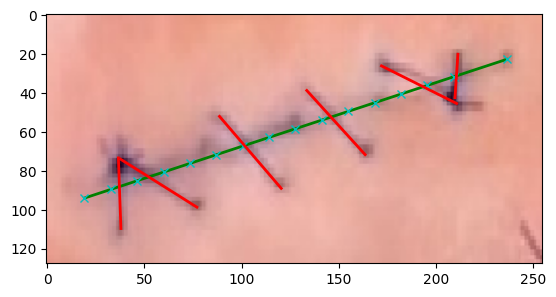

In [5]:
image_id = str(69)
data_inter, images_interpolated = interpolate_to_size(data)

visualize(data_inter, image_id, images_interpolated[image_id])

out_json_p = Path('data')/'data_processed.json'
# store to a new json
with open(out_json_p, 'w') as f:
    json.dump(data, f) 

dim: torch.Size([3, 128, 128])


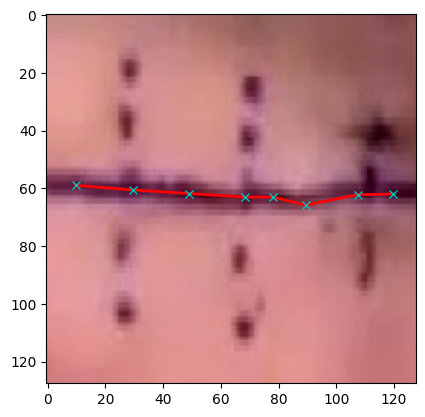

In [67]:
from torch.utils.data import Dataset, DataLoader, random_split

import albumentations as A

transform = A.Compose([
    A.RandomCrop(width=128, height=128),
    A.RandomBrightnessContrast(p=0.5),
], keypoint_params=A.KeypointParams(format='xy'))

dataset = ZdoDataset(out_json_p, transform=transform)

# TODO: train val test into separate jsons
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

dataiter = iter(dataloader)
images, labels = next(dataiter)

# TODO: only incision supported atm
visualize_tensor(images[0], labels[0])
print(f"dim: {images[0].shape}")

In [85]:
# calculate intensity stats
# - mean and std of pixel intensities across the dataset 
d = np.array(list(dataset.images.values()))
#accross all dimenasion except the last one -- channel
mean = d.mean(axis=tuple(range(d.ndim-1))) 
std = d.std(axis=tuple(range(d.ndim-1))) 
print(f"mean = {mean} \nstd = {std}")

mean = [166.25210137 128.91363988 131.47121054] 
std = [47.85307378 43.52442252 44.18917168]


In [17]:
images[0].shape
# transform = transf.Compose([
#     transf.Normalize((128,128,128), (128,128,128)), #0:255 -> -1:1
#     transf.RandomHorizontalFlip(p=0.5),
#     transf.RandomCrop(size=(224,224))
# ])

torch.Size([128, 255, 3])